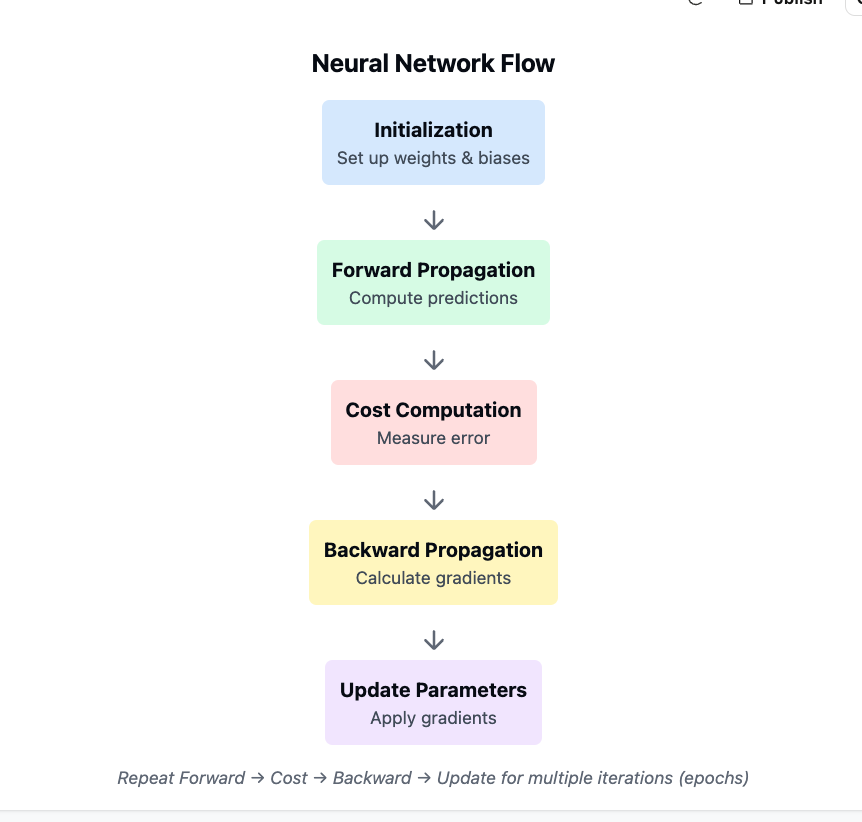

A comprehensive object-oriented implementation of the neural network. Here's a breakdown of the design:

**Architecture Overview**
- The implementation follows proper OOP principles with:

**Abstraction:**
- Base Layer class defines the interface
Encapsulation: Each component manages its own data and behavior
Composition: Network is composed of layers
Single Responsibility: Each class has a focused purpose

**Key Classes**

`Layer (Base Class)`

- Abstract class defining the interface for all layer types
- Contains common attributes like `parameters, cache, and gradients`
- Defines abstract methods that subclasses must implement

`DenseLayer`

- Implements a fully connected layer with customizable activation
- Handles both forward and backward passes
- Maintains its own parameters, cache, and gradients
- Supports both ReLU and sigmoid activations
- Includes parameter update methods

`DeepNeuralNetwork`

- Main class representing the entire neural network
- Stores and manages a collection of layers
- Provides methods for:

- Adding layers manually or auto-building from dimensions
  - Forward propagation through all layers
  - Computing cost
  - Backward propagation
  - Parameter updates
  - Training with configurable parameters
  - Making predictions

## Advantages of This OOP Design

- Modularity: Easy to extend with new layer types or activations
- Readability: Clear separation of responsibilities
- Maintainability: Changes to one component don't affect others
- Reusability: Components can be reused in different networks
- Extensibility: New features can be added without changing existing code

For example, you could easily extend this to support:

1. Dropout layers
2. Batch normalization
3. Convolutional layers
4. Different optimizers (Adam, RMSprop, etc.)
5. Learning rate scheduling

In [ ]:
# Example usage
if __name__ == "__main__":
  # Generate some toy data
  np.random.seed(1)
  X = np.random.randn(2, 400)  # 2-dimensional inputs
  Y = np.random.randint(0, 2, (1, X.shape[1]))  # Binary labels

  # Create and train the model
  model = DeepNeuralNetwork()
  model.build_model([2, 4, 3, 1])  # 2 inputs, 2 hidden layers with 4 and 3 neurons, 1 output

  costs = model.train(X, Y, num_iterations=2000, learning_rate=0.05, print_cost=True)

  # Make predictions
  predictions = model.predict(X)
  accuracy = 100 - np.mean(np.abs(predictions - Y)) * 100
  print(f"Accuracy: {accuracy}%")

In [ ]:
import numpy as np

## 1. Layer (Base Class)

- Abstract class defining the interface for all layer types
- Contains common attributes like parameters, cache, and gradients
- Defines abstract methods that subclasses must implement

In [13]:
class Layer:
  """
  Base class for neural network layers
  """
  def __init__(self):
    self.parameters = {}
    self.cache = {}
    self.grads = {}

  def forward(self, X):
    raise NotImplementedError("Subclasses must implement forward method")

  def backward(self, dA):
    raise NotImplementedError("Subclasses must implement backward method")

## DeepNeuralNetwork

- Main class representing the entire neural network

- Stores and manages a collection of layers

Provides methods for:

- Adding layers manually or auto-building from dimensions

- Forward propagation through all layers
- Computing cost
- Backward propagation
- Parameter updates
- Training with configurable parameters
- Making predictions

In [12]:
class DenseLayer(Layer):
  """
  Implements a fully connected layer with activation
  """

  def __init__(self, input_size, output_size, activation='relu'):
    """
    Initialize a dense layer

    Arguments:

    input_size -- size of the input to this layer
    output_size -- size of the output from this layer
    activation -- activation function, "relu" or "sigmoid"

    """

    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.activation = activation

    # Initialize parameters
    self.parameters["W"] = np.random.randn(output_size, input_size) * 0.01
    self.parameters["b"] = np.zeros((output_size, 1))

  def forward(self, A_prev):
    """
    Implement forward propagation for a dense layer

    Arguments:
    A_prev -- activations from previous layer (or input): (size of previous layer, number of examples)

    Returns:
    A -- output of this layer
    """

    W = self.parameters["W"]
    b = self.parameters["b"]
    Z = np.dot(W, A_prev) + b

    # Store values for backprop
    self.cache["A_prev"] = A_prev
    self.cache["Z"] = Z

    # Apply activation
    if self.activation == "relu":
      A = self._relu(Z)
    elif self.activation == "sigmoid":
      A = self._sigmoid(Z)
    else:
      raise ValueError(f"Unsupported activation: {self.activation}")

    return A

  def backward(self, dA):
    """
    Implement backward propagation for a dense layer

    Arguments:
    dA -- post-activation gradient for current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer)
    """

    A_prev = self.cache["A_prev"]
    Z = self.cache["Z"]
    m = A_prev.shape[1]  # number of examples

    # Get activation gradient
    if self.activation == "relu":
      dZ = self._relu_backward(dA, Z)
    elif self.activation == "sigmoid":
      dZ = self._sigmoid_backward(dA, Z)
    else:
      raise ValueError(f"Unsupported activation: {self.activation}")

    # Calculate gradients
    W = self.parameters["W"]
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    # Store gradients
    self.grads["dW"] = dW
    self.grads["db"] = db

    return dA_prev

  def update_parameters(self, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    learning_rate -- learning rate to use in update
    """

    self.parameters["W"] -= learning_rate * self.grads["dW"]
    self.parameters["b"] -= learning_rate * self.grads["db"]

  def _sigmoid(self, Z):
    """
    Sigmoid activation function
    """
    A = 1 / (1 + np.exp(-Z))
    return A

  def _relu(self, Z):
    """
    ReLU activation function
    """
    A = np.maximum(0, Z)
    return A

  def _sigmoid_backward(self, dA, Z):
    """
    Gradient of sigmoid activation
    """
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

  def _relu_backward(self, dA, Z):
    """
    Gradient of ReLU activation
    """
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ


### Intuitive Explaination of Backprop

What are these variables?

- W: The weight matrix for the current layer
- m: The number of training examples
- dZ: The gradient of the cost with respect to the linear output Z of this layer
- A_prev: Activations from the previous layer (input to this layer)
- dW: Gradient of the cost with respect to weights W
- db: Gradient of the cost with respect to biases b

#### A Visual Guide to Backpropagation in Neural Networks

Let me provide a comprehensive explanation of backpropagation using clear visualizations to make this complex process more understandable.

## 1. Neural Network Foundation

First, let's establish what we're working with:

```
Input Layer → Hidden Layer(s) → Output Layer
   (x)     →      (h)       →     (y)
```

For each layer, we have:
- **Weight matrix W**: Connections between layers
- **Bias vector b**: Offset for each neuron
- **Activation function g**: Adds non-linearity (ReLU, sigmoid, etc.)

## 2. Forward Pass

The forward pass computes predictions:

```
      W[1]          W[2]
      /|\           /|\
       |             |
X → Linear → A[1] → Linear → A[2] (output)
       ↑             ↑
      b[1]          b[2]
      g()           g()
```

For each layer:
```
Z[l] = W[l] × A[l-1] + b[l]   (Linear part)
A[l] = g(Z[l])                (Activation part)
```

Where:
- A[0] = X (input)
- Z[l] is the pre-activation output
- A[l] is the post-activation output

## 3. The Core Problem

We want to minimize a cost function J that measures prediction error:
```
J(W, b) = (1/m) * Σ L(y_true, y_pred)
```

The key question: **How do we adjust W and b to reduce J?**

## 4. Backpropagation Intuition

Backpropagation works backward through the network:

```
Output Layer     ←      Hidden Layer     ←      Input Layer
    ↑                        ↑                     ↑
   dJ/dy                    dJ/dh                 dJ/dx
    ↓                        ↓                     ↓
   dJ/dW[2]                dJ/dW[1]               Inputs
   dJ/db[2]                dJ/db[1]
```

The chain rule of calculus lets us find how each parameter affects the final cost.

## 5. Computing Gradients: The Visual Process

### Computing dZ (Error Signal)

For the output layer:
```
dZ[L] = A[L] - Y  (for binary cross-entropy)
```

For hidden layers:
```
dZ[l] = (W[l+1].T × dZ[l+1]) ⊙ g'(Z[l])
```

Where:
- ⊙ represents element-wise multiplication
- g' is the derivative of the activation function

Visually:
```
       W[l+1].T           g'(Z[l])
        /|\                 /|\
         |                   |
dZ[l+1] → × → (result) → ⊙ → dZ[l]
```

### Computing Weight Gradients (dW)

```
     dZ[l]           A[l-1].T
      /|\             /|\
       |               |
      → × → dW[l] ← →
      
dW[l] = (1/m) × dZ[l] × A[l-1].T
```

Matrix multiplication breakdown:
```
dZ[l] = [  dz1_ex1  dz1_ex2  ...  dz1_exm  ]  ← neuron 1 errors
         [  dz2_ex1  dz2_ex2  ...  dz2_exm  ]  ← neuron 2 errors
         [    ...      ...    ...    ...    ]

A[l-1].T = [  a1_ex1  a2_ex1  ...  an_ex1  ]  ← example 1
           [  a1_ex2  a2_ex2  ...  an_ex2  ]  ← example 2
           [   ...     ...    ...    ...   ]
           [  a1_exm  a2_exm  ...  an_exm  ]  ← example m
```

Each entry dW[i,j] represents how weight connecting neuron j (in prev. layer) to neuron i (in current layer) affects the cost:
```
dW[i,j] = (1/m) × Σ(dz[i] × a[j])
         across all examples
```

### Computing Bias Gradients (db)

```
     dZ[l]          Sum across
      /|\           examples
       |              /|\
      → → (sum) → → → db[l]
      
db[l] = (1/m) × sum(dZ[l], axis=1, keepdims=True)
```

Visually:
```
dZ[l] = [  dz1_ex1  dz1_ex2  ...  dz1_exm  ]  → sum → [ db1 ]
         [  dz2_ex1  dz2_ex2  ...  dz2_exm  ]  → sum → [ db2 ]
         [    ...      ...    ...    ...    ]         [ ... ]
```

Each bias gradient is simply the average error for that neuron across all examples.

## 6. Parameter Update

Finally, we update each parameter using gradient descent:

```
W[l] = W[l] - learning_rate × dW[l]
b[l] = b[l] - learning_rate × db[l]
```

This happens element-wise for every weight and bias in the network:

```
W[l] = [[ w11,  w12,  ...],    -  learning_rate × [[ dw11,  dw12,  ...],
        [ w21,  w22,  ...],                        [ dw21,  dw22,  ...],
        [  ...,  ..., ...]]                        [  ...,  ..., ...]]
```

## 7. The Full Backpropagation Algorithm

1. **Initialize**: Set weights randomly, biases to zero
2. **Forward Pass**: Compute predictions
3. **Compute Cost**: Calculate error between predictions and true values
4. **Backward Pass**:
   - Compute output layer error (dZ[L])
   - For each layer from L down to 1:
     - Compute dW[l] = (1/m) × dZ[l] × A[l-1].T
     - Compute db[l] = (1/m) × sum(dZ[l])
     - Compute dZ[l-1] if not at input layer
5. **Update Parameters**:
   - W[l] = W[l] - learning_rate × dW[l]
   - b[l] = b[l] - learning_rate × db[l]
6. **Repeat** steps 2-5 for multiple epochs

## 8. Why Backpropagation Works

Backpropagation efficiently:
- Determines how each weight contributes to the final error
- Propagates error signals backward through the network
- Makes precise adjustments to reduce error
- Allows deep networks to learn complex patterns

The gradient calculations tell us both:
- **Direction**: Which way to adjust each parameter
- **Magnitude**: How much each parameter should change

This process gradually refines the network's ability to recognize patterns in the data, allowing it to make increasingly accurate predictions.

### DeepNeuralNetwork

In [14]:
class DeepNeuralNetwork:
  """
  A deep neural network model with customizable architecture
  """
  def __init__(self):
    """
    Initialize an empty neural network
    """
    self.layers = []
    self.num_layers = 0

  def add(self, layer):
    """
    Add a layer to the neural network
    """
    self.layers.append(layer)
    self.num_layers += 1

  def build_model(self, layer_dims, hidden_activation="relu", output_activation="sigmoid"):
    """
    Build a network with specified layer dimensions

    Arguments:

    layer_dims -- python array (list) containing the dimensions of each layer in our network
      Ex: # 2 inputs, 2 hidden layers with 4 and 3 neurons, 1 output [2, 2, 4, 3, 1]
    hidden_activation -- activation function for hidden layers
    output_activation -- activation function for output layer

    DenseLayer(self, input_size, output_size, activation='relu')
    """
    for l in range(1, len(layer_dims)):
      if l == len(layer_dims) - 1: # Output layer
        self.add(DenseLayer(layer_dims[l-1], layer_dims[l], activation=output_activation))
      else:
        # hidden layer
        self.add(DenseLayer(layer_dims[l-1], layer_dims[l], activation=hidden_activation))

    return self

  def forward_propagation(self, X):
    """
    Implement forward propagation for the entire network

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)

    Returns:
    AL -- last post-activation value
    """
    A = X
    for layer in self.layers:
      A = layer.forward(A)

    return A

  def compute_cost(self, AL, Y):
    """
    Implement the cost function

    Arguments:
      AL -- probability vector corresponding to label predictions, shape (1, number of examples)
      Y -- true "label" vector, shape (1, number of examples)

    Returns:
      cost -- cross-entropy

    """
    m = Y.shape[1]

    # Compute loss from AL and Y
    cost = (-1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)

    return cost

  def backward_propagation(self, AL, Y):
    """
    Implement backward propagation for the entire network

    Arguments:
    AL -- probability vector, output of the forward propagation
    Y -- true "label" vector

    Returns:
    grads -- python dictionary containing gradients with respect to each parameter
    """

    # Initialize the backpropagation with the gradient of the cost function
    m = Y.shape[1]
    Y = Y.reshape(AL.shape)

    # Gradient of the output layer
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Backward propagation through the network
    dA = dAL

    for layer in reversed(self.layers):
      dA = layer.backward(dA)

  def update_parameters(self, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    learning_rate -- learning rate to be used in the update rule
    """
    for layer in self.layers:
      layer.update_parameters(learning_rate)


  def train(self, X, Y, num_iterations=3000, learning_rate=0.0075, print_cost=False, print_interval=100):
    """
    Train the neural network

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    Y -- true "label" vector, of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- if True, print the cost every print_interval iterations
    print_interval -- how often to print cost

    Returns:
    costs -- list of costs during training
    """

    costs = []
    for i in range(num_iterations):
      # Forward propagation
      AL = self.forward_propagation(X)
      # Compute cost
      cost = self.compute_cost(AL, Y)
      # Backward propagation
      self.backward_propagation(AL, Y)
      # Update parameters
      self.update_parameters(learning_rate)

      # Print cost and store it
      if print_cost and i % print_interval == 0:
        print(f"Cost after iteration {i}: {cost}")
      if i % 100 == 0:
        costs.append(cost)

    return costs

  def predict(self, X, threshold=0.5):
    """
    Use the trained model to predict labels

    Arguments:
      X -- data of examples to predict, numpy array of shape (input size, number of examples)
      threshold -- classification threshold

    Returns:
      predictions -- vector of predictions for X, shape (1, number of examples)
        """
    AL = self.forward_propagation(X)
    predictions = (AL > threshold).astype(int)
    return predictions



In [19]:
# Example usage
if __name__ == "__main__":
  # Generate some toy data
  np.random.seed(1)
  X = np.random.randn(2, 400)  # 2-dimensional inputs
  Y = np.random.randint(0, 2, (1, X.shape[1]))  # Binary labels

  # Create and train the model
  model = DeepNeuralNetwork()
  model.build_model([2, 4, 3, 1])  # 2 inputs, 2 hidden layers with 4 and 3 neurons, 1 output

  costs = model.train(X, Y, num_iterations=10000, learning_rate=0.1, print_cost=True)

  # Make predictions
  predictions = model.predict(X)
  accuracy = 100 - np.mean(np.abs(predictions - Y)) * 100
  print(f"Accuracy: {accuracy}%")

Cost after iteration 0: 0.6931471650780856
Cost after iteration 100: 0.6929484156656779
Cost after iteration 200: 0.6929471569443975
Cost after iteration 300: 0.6929471488898498
Cost after iteration 400: 0.6929471487592775
Cost after iteration 500: 0.6929471486768378
Cost after iteration 600: 0.6929471485127212
Cost after iteration 700: 0.6929471484372971
Cost after iteration 800: 0.6929471483509108
Cost after iteration 900: 0.6929471482600612
Cost after iteration 1000: 0.6929471481786342
Cost after iteration 1100: 0.6929471480816067
Cost after iteration 1200: 0.6929471479929789
Cost after iteration 1300: 0.6929471479044222
Cost after iteration 1400: 0.6929471478144871
Cost after iteration 1500: 0.6929471477258283
Cost after iteration 1600: 0.6929471476352348
Cost after iteration 1700: 0.6929471475437973
Cost after iteration 1800: 0.6929471474542132
Cost after iteration 1900: 0.6929471473618224
Cost after iteration 2000: 0.6929471472710711
Cost after iteration 2100: 0.6929471471781145
